In [1]:


import numpy as np
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import sys
from pathlib import Path


import pandas as pd
import os
# Find project root (the folder containing .git or a marker file)
project_root = Path(__file__).resolve().parents[1] if '__file__' in globals() else Path().resolve()
os.chdir(project_root)
sys.path.append(str(project_root))  # Add to import path


In [2]:

def counterfactual_fairness_analysis(data, model, sensitive_column, fixed_columns, feature_columns):
    results = []
    for index, row in data.iterrows():
        X_original = pd.DataFrame([row.drop(fixed_columns)])
        X_original = X_original.reindex(columns=feature_columns, fill_value=0)
        original_prob = model.predict_proba(X_original)[:, 1][0]

        # Swap sensitive attribute
        row_swapped = row.copy()
        if sensitive_column == 'gender':
            row_swapped[sensitive_column] = 1 - row_swapped[sensitive_column]  # Swap binary gender
        elif sensitive_column.startswith('ethnicity'):
            for col in row_swapped.index:
                if col.startswith('ethnicity_'):
                    row_swapped[col] = 0
            # Flip the first ethnicity to simulate a swap
            for col in row_swapped.index:
                if col.startswith('ethnicity_'):
                    row_swapped[col] = 1
                    break

        X_swapped = pd.DataFrame([row_swapped.drop(fixed_columns)])
        X_swapped = X_swapped.reindex(columns=feature_columns, fill_value=0)
        swapped_prob = model.predict_proba(X_swapped)[:, 1][0]

        delta_prob = swapped_prob - original_prob
        results.append({
            'Index': index,
            'Original_Probability': original_prob,
            'Swapped_Probability': swapped_prob,
            'Delta_Probability': delta_prob
        })
    return pd.DataFrame(results)


In [3]:

def evaluate_all_models(models_dict, test_df, sensitive_columns, feature_columns):
    for model_name, model in models_dict.items():
        print(f"\n=== Counterfactual Fairness for {model_name} ===")
        for sensitive_column in sensitive_columns:
            fixed_columns = [col for col in test_df.columns if col != sensitive_column and not col.startswith('ethnicity')]
            results = counterfactual_fairness_analysis(test_df, model, sensitive_column, fixed_columns, feature_columns)
            mean_delta = results['Delta_Probability'].abs().mean()
            print(f"Mean Δ Probability for {sensitive_column}: {mean_delta:.4f}")


c:\Users\Blake\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Best hyperparameters: {'n_estimators': 323, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': 'balanced'}
F1 Score: 0.7758007117437722
ROC AUC: 0.9656093083936347
Accuracy: 0.9015625
Precision: 0.7171052631578947
Recall: 0.8449612403100775


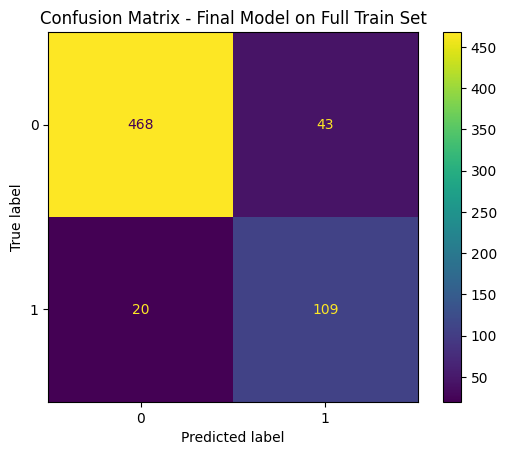


=== Counterfactual Fairness for Random Forest ===
Mean Δ Probability for gender: 0.0057
Mean Δ Probability for ethnicity: 0.0046

=== Counterfactual Fairness for XGBoost ===
Mean Δ Probability for gender: 0.0004
Mean Δ Probability for ethnicity: 0.0000

=== Counterfactual Fairness for Logistic Regression ===
Mean Δ Probability for gender: 0.0173
Mean Δ Probability for ethnicity: 0.0096


In [ ]:

showOutput = False
%run OptimizedRandomForest.ipynb
%run OptimizedXGBoost.ipynb
%run OptimizedCatBoost.ipynb
%run OptimizedLogisticRegression.ipynb

models = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
#    'CatBoost': cb_model,
    'Logistic Regression': lr_model
}
FEATURE_COLUMNS = X.columns.tolist()

evaluate_all_models(models, cleanTest, sensitive_columns=['gender', 'ethnicity'], feature_columns=FEATURE_COLUMNS)
